In [1]:
import torch
import requests
import polars as pl

from io import StringIO

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
base_url = "https://raw.githubusercontent.com/Venkat2811/Analyzing-Book-Data-Hadoop/master/2%20Raw%20Input%20Files/"
filenames = ["BX-Book-Ratings.csv", "BX-Books.csv", "BX-Users.csv"]

dataframes = {}

for filename in filenames:
    url = base_url + filename
    response = requests.get(url)
    response.raise_for_status()
    data = StringIO(response.text)
    df = pl.read_csv(data, separator=';', encoding='latin1', ignore_errors=True, truncate_ragged_lines=True)
    dataframes[filename] = df

users = dataframes["BX-Users.csv"]
books = dataframes["BX-Books.csv"]
ratings = dataframes["BX-Book-Ratings.csv"]

In [3]:
# Display the first few rows of each dataset
print(f"Books")
print(books.describe())
# display a horizontal line to separate the outputs
print('-'*100)
print(f"Users")
print(users.describe())
print('-'*100)
print(f"Ratings")
print(ratings.describe())

Books
shape: (9, 9)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ statistic ┆ ISBN      ┆ Book-Titl ┆ Book-Auth ┆ … ┆ Publisher ┆ Image-URL ┆ Image-URL ┆ Image-UR │
│ ---       ┆ ---       ┆ e         ┆ or        ┆   ┆ ---       ┆ -S        ┆ -M        ┆ L-L      │
│ str       ┆ str       ┆ ---       ┆ ---       ┆   ┆ str       ┆ ---       ┆ ---       ┆ ---      │
│           ┆           ┆ str       ┆ str       ┆   ┆           ┆ str       ┆ str       ┆ str      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ count     ┆ 270760    ┆ 270760    ┆ 270760    ┆ … ┆ 270760    ┆ 270760    ┆ 270730    ┆ 270728   │
│ null_coun ┆ 0         ┆ 0         ┆ 0         ┆ … ┆ 0         ┆ 0         ┆ 30        ┆ 32       │
│ t         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ mean      ┆ null      ┆ null      ┆ null      ┆ … ┆ null      ┆ null 

In [4]:
# Display the first few rows of each dataset
print(books.head())
# display a horizontal line to separate the outputs
print('-'*100)
print(users.head())
print('-'*100)
print(ratings.head())

shape: (5, 8)
┌────────────┬────────────┬────────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│ ISBN       ┆ Book-Title ┆ Book-Autho ┆ Year-Of-P ┆ Publisher ┆ Image-URL ┆ Image-URL ┆ Image-URL │
│ ---        ┆ ---        ┆ r          ┆ ublicatio ┆ ---       ┆ -S        ┆ -M        ┆ -L        │
│ str        ┆ str        ┆ ---        ┆ n         ┆ str       ┆ ---       ┆ ---       ┆ ---       │
│            ┆            ┆ str        ┆ ---       ┆           ┆ str       ┆ str       ┆ str       │
│            ┆            ┆            ┆ i64       ┆           ┆           ┆           ┆           │
╞════════════╪════════════╪════════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 0195153448 ┆ Classical  ┆ Mark P. O. ┆ 2002      ┆ Oxford    ┆ http://im ┆ http://im ┆ http://im │
│            ┆ Mythology  ┆ Morford    ┆           ┆ Universit ┆ ages.amaz ┆ ages.amaz ┆ ages.amaz │
│            ┆            ┆            ┆           ┆ y Press   ┆ on.com/im ┆ 

In [5]:
ratings['Book-Rating'].unique()

Book-Rating
i64
null
0
1
2
3
…
6
7
8


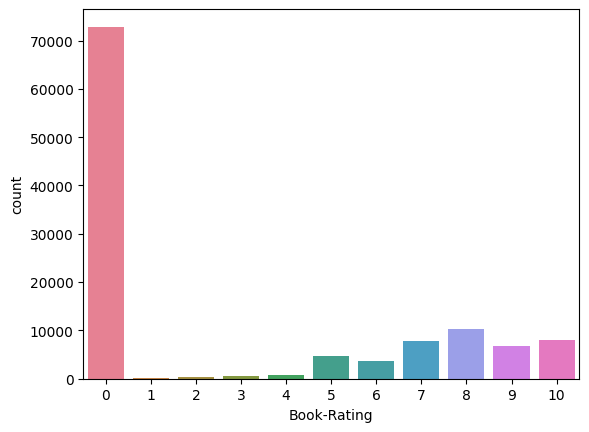

In [6]:
import matplotlib.pyplot as plt 
import seaborn as sns 

x_col = ratings['Book-Rating'].drop_nulls().cast(pl.Int32)
palette = sns.color_palette("husl", len(x_col.unique()))
sns.countplot(x=x_col, palette=palette, hue=x_col, legend=False)
plt.show() 
del x_col, palette

In [7]:
print(len(ratings['User-ID'].unique())) 
print(len(ratings['ISBN'].unique())) 

11364
71760


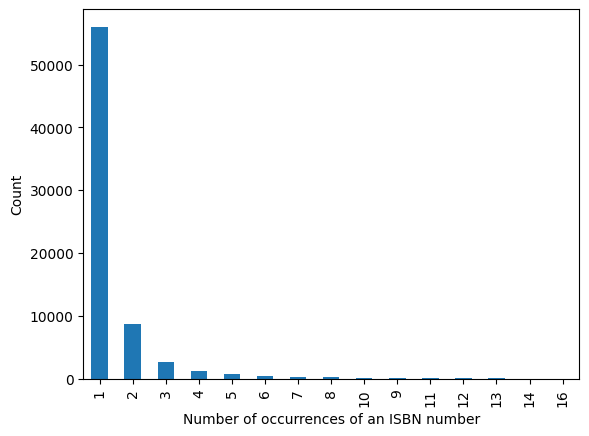

In [9]:
isbn_counts = ratings.group_by('ISBN').agg(pl.count('ISBN').alias('count'))
count_occurrences = isbn_counts.group_by('count').agg(pl.count('count').alias('occurrences'))
count_occurrences_pd = count_occurrences.to_pandas()
count_occurrences_pd = count_occurrences_pd.sort_values(by='occurrences', ascending=False)
count_occurrences_pd[:15].plot(kind='bar', x='count', y='occurrences', legend=False)

plt.xlabel("Number of occurrences of an ISBN number")
plt.ylabel("Count")
plt.show()


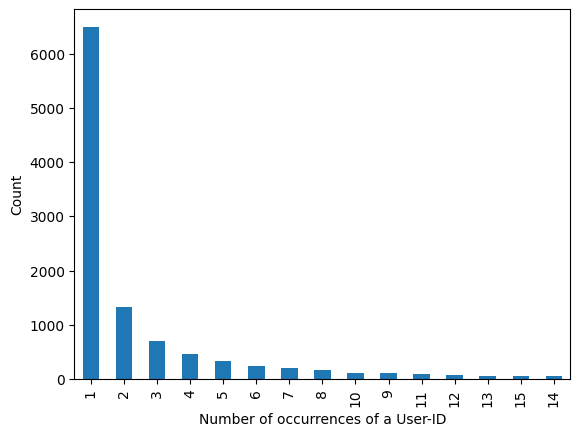

In [10]:
userid_counts = ratings.group_by('User-ID').agg(pl.count('User-ID').alias('count'))
count_occurrences = userid_counts.group_by('count').agg(pl.count('count').alias('occurrences'))
count_occurrences_pd = count_occurrences.to_pandas()
count_occurrences_pd = count_occurrences_pd.sort_values(by='occurrences', ascending=False)
count_occurrences_pd[:15].plot(kind='bar', x='count', y='occurrences', legend=False)

plt.xlabel("Number of occurrences of a User-ID")
plt.ylabel("Count")
plt.show()

In [11]:
import numpy as np
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
from torch import nn, optim, Tensor

from torch_geometric.utils import structured_negative_sampling
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn import LGConv

In [41]:
# Preprocessing
filtered_ratings = ratings.filter(
    pl.col('ISBN').is_in(books['ISBN']) & pl.col('User-ID').is_in(users['User-ID'])
)
# Keep only the ratings >= 8
filtered_ratings = filtered_ratings.filter(pl.col('Book-Rating') >= 8)

df = filtered_ratings.head(10000)

In [42]:
df.head()

User-ID,ISBN,Book-Rating
i64,str,i64
276747,"""0060517794""",9
276747,"""0671537458""",9
276747,"""0679776818""",8
276751,"""3596218098""",8
276754,"""0684867621""",8


In [43]:
# Create mappings
user_mapping = {userid: i for i, userid in enumerate(df['User-ID'].unique())}
item_mapping = {isbn: i for i, isbn in enumerate(df['ISBN'].unique())}

# Count users and items
num_users = len(user_mapping)
num_items = len(item_mapping)
num_total = num_users + num_items

In [44]:
user_ids = torch.LongTensor([user_mapping[i] for i in df['User-ID']])
item_ids = torch.LongTensor([item_mapping[i] for i in df['ISBN']])
edge_index = torch.stack((user_ids, item_ids))

In [45]:
# Create training, validation, and test adjacency matrices
train_index, test_index = train_test_split(range(len(df)), test_size=0.2, random_state=0)
val_index, test_index = train_test_split(test_index, test_size=0.5, random_state=0)

train_edge_index = edge_index[:, train_index]
val_edge_index = edge_index[:, val_index]
test_edge_index = edge_index[:, test_index]

In [46]:
def sample_mini_batch(edge_index, batch_size=128):
    # Generate BATCH_SIZE random indices
    index = np.random.choice(range(edge_index.shape[1]), size=batch_size)

    # Generate negative sample indices
    edge_index = structured_negative_sampling(edge_index)
    edge_index = torch.stack(edge_index, dim=0)
    
    user_index = edge_index[0, index]
    pos_item_index = edge_index[1, index]
    neg_item_index = edge_index[2, index]
    
    return user_index, pos_item_index, neg_item_index

In [47]:
class LightGCN(nn.Module):
    def __init__(self, num_users, num_items, num_layers=4, dim_h=64):
        super().__init__()
        
        self.num_users = num_users
        self.num_items = num_items
        self.num_layers = num_layers
        self.emb_users = nn.Embedding(num_embeddings=self.num_users, embedding_dim=dim_h)
        self.emb_items = nn.Embedding(num_embeddings=self.num_items, embedding_dim=dim_h)

        self.convs = nn.ModuleList(LGConv() for _ in range(num_layers))

        nn.init.normal_(self.emb_users.weight, std=0.01)
        nn.init.normal_(self.emb_items.weight, std=0.01)

    def forward(self, edge_index):
        emb = torch.cat([self.emb_users.weight, self.emb_items.weight])
        embs = [emb]

        for conv in self.convs:
            emb = conv(x=emb, edge_index=edge_index)
            embs.append(emb)

        emb_final = 1/(self.num_layers+1) * torch.mean(torch.stack(embs, dim=1), dim=1)

        emb_users_final, emb_items_final = torch.split(emb_final, [self.num_users, self.num_items])

        return emb_users_final, self.emb_users.weight, emb_items_final, self.emb_items.weight

In [48]:
def bpr_loss(emb_users_final, emb_users, emb_pos_items_final, emb_pos_items, emb_neg_items_final, emb_neg_items, LAMBDA=0.01):
    reg_loss = LAMBDA * (emb_users.norm().pow(2) +
                        emb_pos_items.norm().pow(2) +
                        emb_neg_items.norm().pow(2))

    pos_ratings = torch.mul(emb_users_final, emb_pos_items_final).sum(dim=-1)
    neg_ratings = torch.mul(emb_users_final, emb_neg_items_final).sum(dim=-1)

    bpr_loss = torch.mean(torch.nn.functional.softplus(pos_ratings - neg_ratings))
    # bpr_loss = torch.mean(torch.nn.functional.logsigmoid(pos_ratings - neg_ratings))

    return -bpr_loss + reg_loss

In [49]:
def get_user_items(edge_index):
    user_items = dict()
    for i in range(edge_index.shape[1]):
        user = edge_index[0][i].item()
        item = edge_index[1][i].item()
        if user not in user_items:
            user_items[user] = []
        user_items[user].append(item)
    return user_items

In [50]:
def compute_recall_at_k(items_ground_truth, items_predicted):
    num_correct_pred = np.sum(items_predicted, axis=1)
    num_total_pred = np.array([len(items_ground_truth[i]) for i in range(len(items_ground_truth))])

    recall = np.mean(num_correct_pred / num_total_pred)

    return recall

In [51]:
def compute_ndcg_at_k(items_ground_truth, items_predicted, K=20):
    test_matrix = np.zeros((len(items_predicted), K))

    for i, items in enumerate(items_ground_truth):
        length = min(len(items), K)
        test_matrix[i, :length] = 1
    
    max_r = test_matrix
    idcg = np.sum(max_r * 1. / np.log2(np.arange(2, K + 2)), axis=1)
    dcg = items_predicted * (1. / np.log2(np.arange(2, K + 2)))
    dcg = np.sum(dcg, axis=1)
    idcg[idcg == 0.] = 1.
    ndcg = dcg / idcg
    ndcg[np.isnan(ndcg)] = 0.
    
    return np.mean(ndcg)

In [52]:
# wrapper function to get evaluation metrics
def get_metrics(model, edge_index, exclude_edge_indices, K=20):

    ratings = torch.matmul(model.emb_users.weight, model.emb_items.weight.T)

    for exclude_edge_index in exclude_edge_indices:
        user_pos_items = get_user_items(exclude_edge_index)
        exclude_users = []
        exclude_items = []
        for user, items in user_pos_items.items():
            exclude_users.extend([user] * len(items))
            exclude_items.extend(items)
        ratings[exclude_users, exclude_items] = -1024

    # get the top k recommended items for each user
    _, top_K_items = torch.topk(ratings, k=K)

    # get all unique users in evaluated split
    users = edge_index[0].unique()

    test_user_pos_items = get_user_items(edge_index)

    # convert test user pos items dictionary into a list
    test_user_pos_items_list = [test_user_pos_items[user.item()] for user in users]

    # determine the correctness of topk predictions
    items_predicted = []
    for user in users:
        ground_truth_items = test_user_pos_items[user.item()]
        label = list(map(lambda x: x in ground_truth_items, top_K_items[user]))
        items_predicted.append(label)

    recall = compute_recall_at_k(test_user_pos_items_list, items_predicted)
    ndcg = compute_ndcg_at_k(test_user_pos_items_list, items_predicted, K=K)

    return recall, ndcg

In [53]:
# wrapper function to evaluate model
def test(model, edge_index, exclude_edge_indices, K=20):
    emb_users_final, emb_users, emb_items_final, emb_items = model.forward(edge_index)
    user_indices, pos_item_indices, neg_item_indices = structured_negative_sampling(edge_index, contains_neg_self_loops=False)

    emb_users_final, emb_users = emb_users_final[user_indices], emb_users[user_indices]

    emb_pos_items_final, emb_pos_items = emb_items_final[pos_item_indices], emb_items[pos_item_indices]
    emb_neg_items_final, emb_neg_items = emb_items_final[neg_item_indices], emb_items[neg_item_indices]

    loss = bpr_loss(emb_users_final, emb_users, emb_pos_items_final, emb_pos_items, emb_neg_items_final, emb_neg_items).item()

    recall, ndcg = get_metrics(model, edge_index, exclude_edge_indices, K=K)

    return loss, recall, ndcg

In [54]:
K = 20
LAMBDA = 1e-6
BATCH_SIZE = 128

In [55]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LightGCN(num_users, num_items)
model = model.to(device)
edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
val_edge_index = val_edge_index.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [56]:
%%time
from tqdm import tqdm

n_batch = int(len(train_index)/BATCH_SIZE)

for epoch in tqdm(range(100)):
    model.train()

    for _ in range(n_batch):
        optimizer.zero_grad()

        emb_users_final, emb_users, emb_items_final, emb_items = model.forward(train_edge_index)

        user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(train_edge_index, batch_size=BATCH_SIZE)
        
        emb_users_final, emb_users = emb_users_final[user_indices], emb_users[user_indices]
        emb_pos_items_final, emb_pos_items = emb_items_final[pos_item_indices], emb_items[pos_item_indices]
        emb_neg_items_final, emb_neg_items = emb_items_final[neg_item_indices], emb_items[neg_item_indices]

        train_loss = bpr_loss(emb_users_final, emb_users, emb_pos_items_final, emb_pos_items, emb_neg_items_final, emb_neg_items, LAMBDA)

        train_loss.backward()
        optimizer.step()

    if epoch % 5 == 0:
        model.eval()
        val_loss, recall, ndcg = test(model, val_edge_index, [train_edge_index], K)
        print(f"Epoch {epoch} | Train loss: {train_loss.item():.5f} | Val loss: {val_loss:.5f} | Val recall@{K}: {recall:.5f} | Val ndcg@{K}: {ndcg:.5f}")

  1%|          | 1/100 [00:01<02:40,  1.62s/it]

Epoch 0 | Train loss: -0.69315 | Val loss: -0.46585 | Val recall@20: 0.00617 | Val ndcg@20: 0.00259


  6%|▌         | 6/100 [00:08<02:06,  1.35s/it]

Epoch 5 | Train loss: -0.69382 | Val loss: 3.92171 | Val recall@20: 0.00047 | Val ndcg@20: 0.00017


 11%|█         | 11/100 [00:14<01:55,  1.29s/it]

Epoch 10 | Train loss: -0.69550 | Val loss: 17.40096 | Val recall@20: 0.00000 | Val ndcg@20: 0.00000


 16%|█▌        | 16/100 [00:20<01:49,  1.30s/it]

Epoch 15 | Train loss: -0.70285 | Val loss: 38.75788 | Val recall@20: 0.00027 | Val ndcg@20: 0.00012


 21%|██        | 21/100 [00:26<01:41,  1.28s/it]

Epoch 20 | Train loss: -0.72223 | Val loss: 73.07019 | Val recall@20: 0.00027 | Val ndcg@20: 0.00015


 26%|██▌       | 26/100 [00:33<01:35,  1.29s/it]

Epoch 25 | Train loss: -0.71203 | Val loss: 127.33568 | Val recall@20: 0.00027 | Val ndcg@20: 0.00016


 31%|███       | 31/100 [00:39<01:32,  1.34s/it]

Epoch 30 | Train loss: -0.73678 | Val loss: 209.51831 | Val recall@20: 0.00217 | Val ndcg@20: 0.00071


 36%|███▌      | 36/100 [00:46<01:26,  1.36s/it]

Epoch 35 | Train loss: -0.88162 | Val loss: 333.42587 | Val recall@20: 0.00217 | Val ndcg@20: 0.00088


 41%|████      | 41/100 [00:52<01:19,  1.34s/it]

Epoch 40 | Train loss: -1.04415 | Val loss: 490.40512 | Val recall@20: 0.00217 | Val ndcg@20: 0.00090


 46%|████▌     | 46/100 [00:58<01:09,  1.29s/it]

Epoch 45 | Train loss: -1.13995 | Val loss: 687.41913 | Val recall@20: 0.00217 | Val ndcg@20: 0.00120


 51%|█████     | 51/100 [01:05<01:03,  1.30s/it]

Epoch 50 | Train loss: -0.94410 | Val loss: 915.31879 | Val recall@20: 0.00407 | Val ndcg@20: 0.00194


 56%|█████▌    | 56/100 [01:11<00:57,  1.30s/it]

Epoch 55 | Train loss: -1.50648 | Val loss: 1179.99963 | Val recall@20: 0.00407 | Val ndcg@20: 0.00165


 61%|██████    | 61/100 [01:17<00:50,  1.29s/it]

Epoch 60 | Train loss: -1.68939 | Val loss: 1474.83862 | Val recall@20: 0.00407 | Val ndcg@20: 0.00204


 66%|██████▌   | 66/100 [01:23<00:44,  1.31s/it]

Epoch 65 | Train loss: -2.07808 | Val loss: 1818.91931 | Val recall@20: 0.00470 | Val ndcg@20: 0.00287


 71%|███████   | 71/100 [01:30<00:38,  1.31s/it]

Epoch 70 | Train loss: -2.56056 | Val loss: 2191.49097 | Val recall@20: 0.00430 | Val ndcg@20: 0.00373


 76%|███████▌  | 76/100 [01:36<00:30,  1.29s/it]

Epoch 75 | Train loss: -2.49274 | Val loss: 2596.62158 | Val recall@20: 0.00407 | Val ndcg@20: 0.00362


 81%|████████  | 81/100 [01:42<00:24,  1.31s/it]

Epoch 80 | Train loss: -3.17502 | Val loss: 3032.18164 | Val recall@20: 0.00430 | Val ndcg@20: 0.00443


 86%|████████▌ | 86/100 [01:48<00:18,  1.29s/it]

Epoch 85 | Train loss: -3.49831 | Val loss: 3487.77100 | Val recall@20: 0.00494 | Val ndcg@20: 0.00464


 91%|█████████ | 91/100 [01:55<00:11,  1.31s/it]

Epoch 90 | Train loss: -4.87974 | Val loss: 4008.40894 | Val recall@20: 0.00494 | Val ndcg@20: 0.00466


 96%|█████████▌| 96/100 [02:01<00:05,  1.33s/it]

Epoch 95 | Train loss: -3.21454 | Val loss: 4525.77783 | Val recall@20: 0.00494 | Val ndcg@20: 0.00469


100%|██████████| 100/100 [02:06<00:00,  1.27s/it]

CPU times: user 2min 4s, sys: 723 ms, total: 2min 4s
Wall time: 2min 6s
